## Predicting page rank using Text and Price

First part of my dissertation project focused on text processing. I gather Amazon UK data regarding the Skincare market. I filtered only the page rank (target) and price and text (name + description) which will be the predictors.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [170]:
# Import the dataset I previously cleansed
SkinTextRed2 = pd.read_csv("Skincare2Yreduced.csv")

In [121]:
SkinTextRed2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935934 entries, 0 to 935933
Data columns (total 3 columns):
Text     935934 non-null object
price    935934 non-null float64
rank     935934 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.4+ MB


In [171]:
# Group by text to delete duplicates, keeping the mean for price and rank
SkinTextRed=SkinTextRed2.groupby(['Text'], as_index=False).mean()

In [123]:
# only 25000 left
SkinTextRed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25293 entries, 0 to 25292
Data columns (total 3 columns):
Text     25293 non-null object
price    25293 non-null float64
rank     25293 non-null float64
dtypes: float64(2), object(1)
memory usage: 790.4+ KB


In [172]:
# Additional cleansing needed
SkinTextRed['Text'] = SkinTextRed['Text'].str.replace(r"[|&•–�®∙*#]", " ")

In [173]:
# LET'S TRY TO REMOVE STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

In [174]:
# nltk.download('stopwords')
# nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

In [175]:
SkinTextRed['Text'] = SkinTextRed['Text'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))

In [176]:
# APPLY STEMMING !
from nltk.stem import PorterStemmer 
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import WhitespaceTokenizer

ps = PorterStemmer() 

In [177]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [ps.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

SkinTextRed['TextSt'] = SkinTextRed['Text'].apply(stem_sentences)

In [130]:
SkinTextRed['TextSt'].head()
# IT WORKED !

0    10 pack alo pura alo vera sun lotion 200ml 10 ...
1    10 pack alo pura alo vera sun lotion 200ml 10 ...
2    10 pack avalon rejuv oil free moistur 50ml 10 ...
3    10 pack avalon rejuv oil free moistur 50ml 10 ...
4    10 pack avalon rosemari hand bodi lotion 350ml...
Name: TextSt, dtype: object

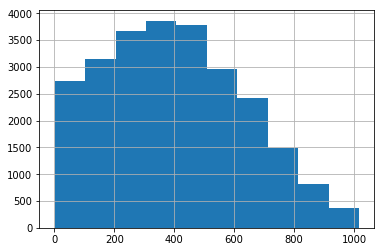

In [178]:
# How is the rank variable distributed?
SkinTextRed['rank'].hist()

In [179]:
# I label the ranks as 0 or 1 to have a binary target
def label_rank (row):
   if row['rank'] > 700 : #products not in the first page
      return 0
   if row['rank'] < 100: #product in the first page
      return 1

In [180]:
SkinTextRed.apply (lambda row: label_rank (row),axis=1)
SkinTextRed['rank'] = SkinTextRed.apply (lambda row: label_rank (row),axis=1)

In [192]:
SkinTextRed = SkinTextRed.dropna()
SkinTextRed['rank'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5608 entries, 9 to 25277
Data columns (total 4 columns):
Text      5608 non-null object
price     5608 non-null float64
rank      5608 non-null float64
TextSt    5608 non-null object
dtypes: float64(2), object(2)
memory usage: 219.1+ KB


In [182]:
# In order to use the text as predictor I have to Vectorize
cv = CountVectorizer(binary=True)
cv.fit(SkinTextRed['TextSt'])
X = cv.transform(SkinTextRed['TextSt'])
X2 = SkinTextRed['price']
y = SkinTextRed['rank']
Y = y.reset_index()
Y1=Y.drop(['index'], axis=1)

In [183]:
X4 = pd.DataFrame(X.toarray())
X5 = X2.reset_index()
X6 = X5.drop(['index'], axis=1)

In [184]:
X9 = pd.merge(X4, X6, left_index=True, right_index=True)

In [205]:
# convert floats to int to save memory
X9['price']=X9['price'].real.astype(int,casting='unsafe')
Y1['rank']=Y1['rank'].real.astype(int,casting='unsafe')

In [206]:
Y1['rank'].value_counts()

0    2945
1    2663
Name: rank, dtype: int64

In [207]:
# Merge the sparse matrix with price so to use both in the model
X10 = pd.merge(X9, Y1, left_index=True, right_index=True)
X10.head()

,0,1,2,3,4,5,6,7,8,9,...,19717,19718,19719,19720,19721,19722,19723,19724,price,rank
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,64,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,106,1


In [208]:
X10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5608 entries, 0 to 5607
Columns: 19727 entries, 0 to rank
dtypes: int32(2), int64(19725)
memory usage: 844.0 MB


In [209]:
# Stratified split that keeps the original proportions.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
random_state=42)
for train_index, test_index in split.split(X10, X10["rank"]):
  strat_train_set = X10.loc[train_index]
  strat_test_set = X10.loc[test_index]

In [210]:
# Separate predictors and target
train_predictors3 = strat_train_set.drop('rank', axis=1)
train_target3 = strat_train_set['rank']
test_predictors3 = strat_test_set.drop('rank', axis=1)
test_target3 = strat_test_set['rank']

In [211]:
train_target3.value_counts()
test_target3.value_counts()

0    589
1    533
Name: rank, dtype: int64

In [212]:
X_train3, X_val3, y_train3, y_val3 = train_test_split(
    train_predictors3, train_target3, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train3, y_train3)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val3, lr.predict(X_val3))))

C:\Users\franc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.7807486631016043


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.05: 0.7994652406417112


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.25: 0.7932263814616756


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.5: 0.7914438502673797


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=1: 0.7914438502673797


In [213]:
# Logistic Regression
final_model3 = LogisticRegression(C=0.05)
final_model3.fit(train_predictors3, train_target3)
y_pred3 = final_model3.predict(test_predictors3)  
print(confusion_matrix(test_target3, y_pred3))  
print(classification_report(test_target3, y_pred3)) 
# NOT SO BAD, WE CAN ASSUME THAT A PRODUCT IS 80% LIKELY TO END ON THE FIRST PAGE

C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[488 101]
 [131 402]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       589
           1       0.80      0.75      0.78       533

   micro avg       0.79      0.79      0.79      1122
   macro avg       0.79      0.79      0.79      1122
weighted avg       0.79      0.79      0.79      1122



Around 5000 unique products over the last 2 years, I used title, description and avgPrice to estimate which one of them is likely to be on the first page (avgRank<100 against avgRank>700). It gives us an idea if a product (title, description and price) is more related to the upper part of page rank or to the bottom part with 80% accuracy.

In [219]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model3.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('return', 0.6501747320672826)
('indic', 0.5786871149832319)
('scrub', 0.4981982564755433)
('overviewritu', 0.47950666199779374)
('proven', 0.4295953285777716)


In [220]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('mask', -0.5475147033290538)
('lotion', -0.5190526917543132)
('75', -0.47663609579005395)
('argan', -0.4455899901678434)
('foot', -0.3532340396232304)


In [214]:
# text only
X11 = pd.merge(X4, Y1, left_index=True, right_index=True)

In [215]:
# Stratified split that keeps the original proportions.
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
random_state=42)
for train_index, test_index in split.split(X11, X11["rank"]):
  strat_train_set = X11.loc[train_index]
  strat_test_set = X11.loc[test_index]

In [216]:
# Separate predictors and target
train_predictors4 = strat_train_set.drop('rank', axis=1)
train_target4 = strat_train_set['rank']
test_predictors4 = strat_test_set.drop('rank', axis=1)
test_target4 = strat_test_set['rank']

In [217]:
X_train4, X_val4, y_train4, y_val4 = train_test_split(
    train_predictors4, train_target4, train_size = 0.75
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train4, y_train4)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val4, lr.predict(X_val4))))

C:\Users\franc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.7620320855614974


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.05: 0.7834224598930482


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.25: 0.7816399286987522


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.5: 0.7754010695187166


C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=1: 0.7762923351158645


In [218]:
final_model4 = LogisticRegression(C=0.05)
final_model4.fit(train_predictors4, train_target4)
y_pred4 = final_model4.predict(test_predictors4)  
print(confusion_matrix(test_target4, y_pred4))  
print(classification_report(test_target4, y_pred4)) 
# SLIGHTLY LESS, THE PRICE IS HELPING

C:\Users\franc\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[487 102]
 [146 387]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       589
           1       0.79      0.73      0.76       533

   micro avg       0.78      0.78      0.78      1122
   macro avg       0.78      0.78      0.78      1122
weighted avg       0.78      0.78      0.78      1122



## Questions

- Is there a better way to combine the text vector with Price?
- Try other algorithms.
- How do I solve the Memory Error problem?
- Suggested reading on text analytics